### Detect lines in the image

In [1]:
# function to show an image
from matplotlib import pyplot as plt
def show(img, title = "", save=False):
    plt.imshow(img,  cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save:
        plt.savefig(title, dpi = 200)
#         cv2.imwrite(title,img)
    plt.show()

In [2]:
import cv2
import numpy as np
import os

path = 'imgs'

# Detect lines using Canny & Hough 
def detect_lines(img_file, filter_params, canny_params, hough_params):
    cnt = 0
    valid_lines = []
    f_p1, f_p2, f_p3 = filter_params 
    c_p1, c_p2 = canny_params
    h_p1, h_p2, h_p3 = hough_params
    img = cv2.imread(os.path.join(path, img_file),0)  # read image in grey scale
#     show(img, 'Original '+img_file, save=True)
    edges = cv2.Canny(img, c_p1, c_p2,apertureSize=3,L2gradient=True)
#     show(edges, 'No filtered Canny'+img_file, save=True)
    filtered = cv2.bilateralFilter(img,f_p1, f_p2, f_p3)
#     show(filtered, 'Filtered image '+ img_file, save=True)
    filtered_edges = cv2.Canny(filtered, c_p1, c_p2, apertureSize=3,L2gradient=True)
#     show(filtered_edges, 'Filtered Canny'+img_file, save=True)
    
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
    
    lines = cv2.HoughLinesP(filtered_edges,1,np.pi/180, h_p1, h_p2, h_p3)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            
            if abs(slope) <= 0.1:        # exclude horizontal lines
                cv2.line(color_img,(x1,y1),(x2,y2),(0,255,0),2) 
            elif abs(slope) > 4:                # exclude vertical lines
                cv2.line(color_img,(x1,y1),(x2,y2),(255,0,0),2)
            else:
                cv2.line(color_img,(x1,y1),(x2,y2),(0, 0, 255),2)
                valid_lines.append([x1,y1,x2,y2])
                cnt += 1
                
#     plt.imshow(color_img) 
#     plt.title("Hough lines "+ img_file)
#     plt.axis('off')
#     cv2.imwrite('Hough lines'+ img_file, color_img)
#     plt.show()
    
    return valid_lines

### RANSAC to locate the vanishing point

In [3]:
import numpy as np

# Find an intersection point of line1 and line2
def find_intersection_point(line1, line2, xlims, ylims):
    l1_x1, l1_y1, l1_x2, l1_y2 = line1
    l2_x1, l2_y1, l2_x2, l2_y2 = line2
    xdiff = (l1_x1 - l1_x2, l2_x1 - l2_x2)
    ydiff = (l1_y1 - l1_y2, l2_y1 - l2_y2)

    def det(a, b):
        x1, y1 = a
        x2, y2 = b
        return x1 * y2 - y1 * x2
    div = det(xdiff, ydiff)
    
    if div == 0:                  # parallel lines
        return None
    
    d = (det((l1_x1, l1_y1), (l1_x2, l1_y2)), det((l2_x1, l2_y1), (l2_x2, l2_y2)))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    
    if x < xlims[0] or x > xlims[1] or y < ylims[1] or y > ylims[0]:  # points are out of image plane
        return None
                
    return (x, y)

# Find the distance from a point to a line (code below is from worksheet07)
def find_dist_to_line(slope, y_intercept, x0, y0):
    x = (x0 + slope*y0 - slope*y_intercept)/(1 + slope**2)
    y = (slope*x0 + (slope**2)*y0 - (slope**2)*y_intercept)/(1 + slope**2) + y_intercept
    dist = math.sqrt((x - x0)**2 + (y - y0)**2)
 
    return dist


#### RANSAC loop

In [4]:
import random

# Find the vanishing point 
def ransac_loop(lines, n_iteration, n_sample, dist_t, xlim, ylim, img_ = None):
    max_num_inlier = -np.inf
    vanishing_point = None
    vanishing_point_total_dist = 0 
    total_points = []
    for i in range(n_iteration):
        random_lines = random.sample(lines, n_sample) if n_sample < len(lines) else lines
        points = []     # potential vanishing points

        for i in range(len(random_lines)):
            line1 = random_lines[i]
            
            for k in range(len(random_lines)):
                if i == k:
                    continue
                line2 = random_lines[k]
                point = find_intersection_point(line1, line2, xlim, ylim)
                if point != None:
                    points.append(point)
                    total_points.append(point)
                    
        # to choose the better point with less total distance when there are multiple points 
        # having the same number of inliers
    
        # count inliers within a pre-defined distance
        for point in points:
            x, y = point
            num_inliers = 0
            total_dist = 0
            
            for line in lines:
                x1, y1, x2, y2 = line
                slope = (y2-y1)/(x2-x1)
                y_intercept = -x1*slope+y1
                dist = find_dist_to_line(slope, y_intercept, x, y)

                if dist <= dist_t:
                    num_inliers += 1
                    total_dist += dist
                    
            if (num_inliers == max_num_inlier and total_dist < vanishing_point_total_dist) \
                or (num_inliers > max_num_inlier):

                max_num_inlier = num_inliers
                vanishing_point = point
                vanishing_point_total_dist = total_dist
                
        total_points.append(points)

## code below is for error check and debugging        
#     if intersection_point == None:
#         print('Error')
    
#     print(max_num_inlier, vanishing_point)
#     print('total points # ', len(total_points))
    
#     if img_ != None:
#         img = cv2.imread(os.path.join(path, img_),0)
#         plt.imshow(img, cmap='gray')
#         for i in range(len(total_points)):
#             x, y = total_points[i][0], total_points[i][1]
#             plt.scatter(x,y,zorder=i+2, s = 3.0, c = 'lightyellow')
#         if xlim[0] <= vanishing_point[0] <= xlim[1] and ylim[1] <= vanishing_point[1] <= ylim[0]:
#             plt.scatter(gt_dic[img_][0], gt_dic[img_][1],zorder=i+2, s = 6.0, c = 'green')
#             plt.scatter(vanishing_point[0], vanishing_point[1],zorder=i+2, s = 6.0, c = 'red')
#             plt.axis('off')
#             plt.savefig('Intersection points (10_10) '+ img_,dpi=250)
#             plt.show()

    return vanishing_point
            

### Main function and evaluation

In [5]:
# read GT locations of images
import csv
gt_dic = {}    
with open('vanishing_points.csv') as gt_file:
    ground_truth = csv.reader(gt_file, delimiter=',')
    cnt = 0
    for gt in ground_truth:
        if cnt == 0:
            print(f'Columns: {gt[0]}, {gt[1]}, {gt[2]}')
        else:
            gt_dic[gt[0]] = [int(gt[1]), int(gt[2])]
        cnt += 1
    print(f'Processed totla {cnt} lines.')

Columns: ﻿image, x, y
Processed totla 13 lines.


In [8]:
# function to calculate mean squared euclidean distance (MSED) between the predicted and GT vanishing points
import math
msed_dic = {}
def compute_MSED(pred_dic, gt_dic): 
    sum_dist = 0
    num_dist = len(gt_dic.keys())
    for img in pred_dic.keys():
        gt_x, gt_y = gt_dic[img] 
        pred_x, pred_y = pred_dic[img]
        squared_euclidean_dist = (pred_x - gt_x)**2 + (pred_y - gt_y)**2  # squared distance
        sum_dist += squared_euclidean_dist
        msed_dic[img] = squared_euclidean_dist
    print(msed_dic)
    return (sum_dist/num_dist), msed_dic

In [14]:
# main function 
def main(imgs, n_iteration, n_sample, dist_t, filter_params, canny_paramsm, hough_params):
    pred_dic = {} 
    for img in imgs:
        lines = detect_lines(img, filter_params, canny_params, hough_params)
        height, width = cv2.imread(os.path.join(path, img),0).shape[:2]
        point = ransac_loop(lines, n_iteration, n_sample, dist_t,(0,width), (height,0), img)
        pred_dic[img] = point
        print(img, ":",point)
    msed, msed_dic = compute_MSED(pred_dic, gt_dic)    
    print(f'Accuracy(msed): {msed}\n')
    return msed, msed_dic


In [1]:
# experimental parameters from the experiments below
filter_params = (3, 90 , 90) 
canny_params = (50, 150)        # 50, 150
hough_params = (80, 100, 15)    # 80, 100, 15

In [17]:
dic = {'id': [], 'msed': []}
msed_list = []
for i in range(2):
    print(f'run {i+1}')
    msed, msed_dic = main(gt_dic.keys(), 10, 10, 5, filter_params, canny_params, hough_params)
    for k in gt_dic.keys():
        dic['id'].append(k)
        dic['msed'].append(msed_dic[k])
    msed_list.append(msed)
print(np.mean(msed_list))

run 1


/Users/heekim/opt/anaconda3/envs/CV/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in int_scalars


img1.jpg : (404.9604743083004, 182.64822134387353)
img3.jpg : (396.02836879432624, 275.8936170212766)
img6.jpg : (377.6380051590714, 256.78675838349096)
img7.jpg : (379.53710247349824, 423.9328621908127)
img9.jpg : (440.8291457286432, 369.72361809045225)
img10.jpg : (237.2222808870116, 471.5844772967265)
img13.jpg : (388.44615384615383, 258.46153846153845)
img14.jpg : (363.2178217821782, 267.9504950495049)
img15.jpg : (411.46715328467155, 272.45985401459853)
img18.jpg : (290.98924731182797, 214.86021505376345)
img20.jpg : (399.9268292682927, 289.8536585365854)
img21.jpg : (392.85714285714283, 206.14285714285714)
{'img1.jpg': 1.0462591198112325, 'img3.jpg': 0.012122126653585485, 'img6.jpg': 1.6029954848883974, 'img7.jpg': 1.158710934085846, 'img9.jpg': 15.422161056538801, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 4.482021042895163, 'img20.jpg': 40.319452706722146, 'img21.jpg': 18.32653061

In [354]:
df_dic = pd.DataFrame(dic)
df_dic.rename(columns = {'id' :'image', 'msed':'MSED'}, inplace = True)

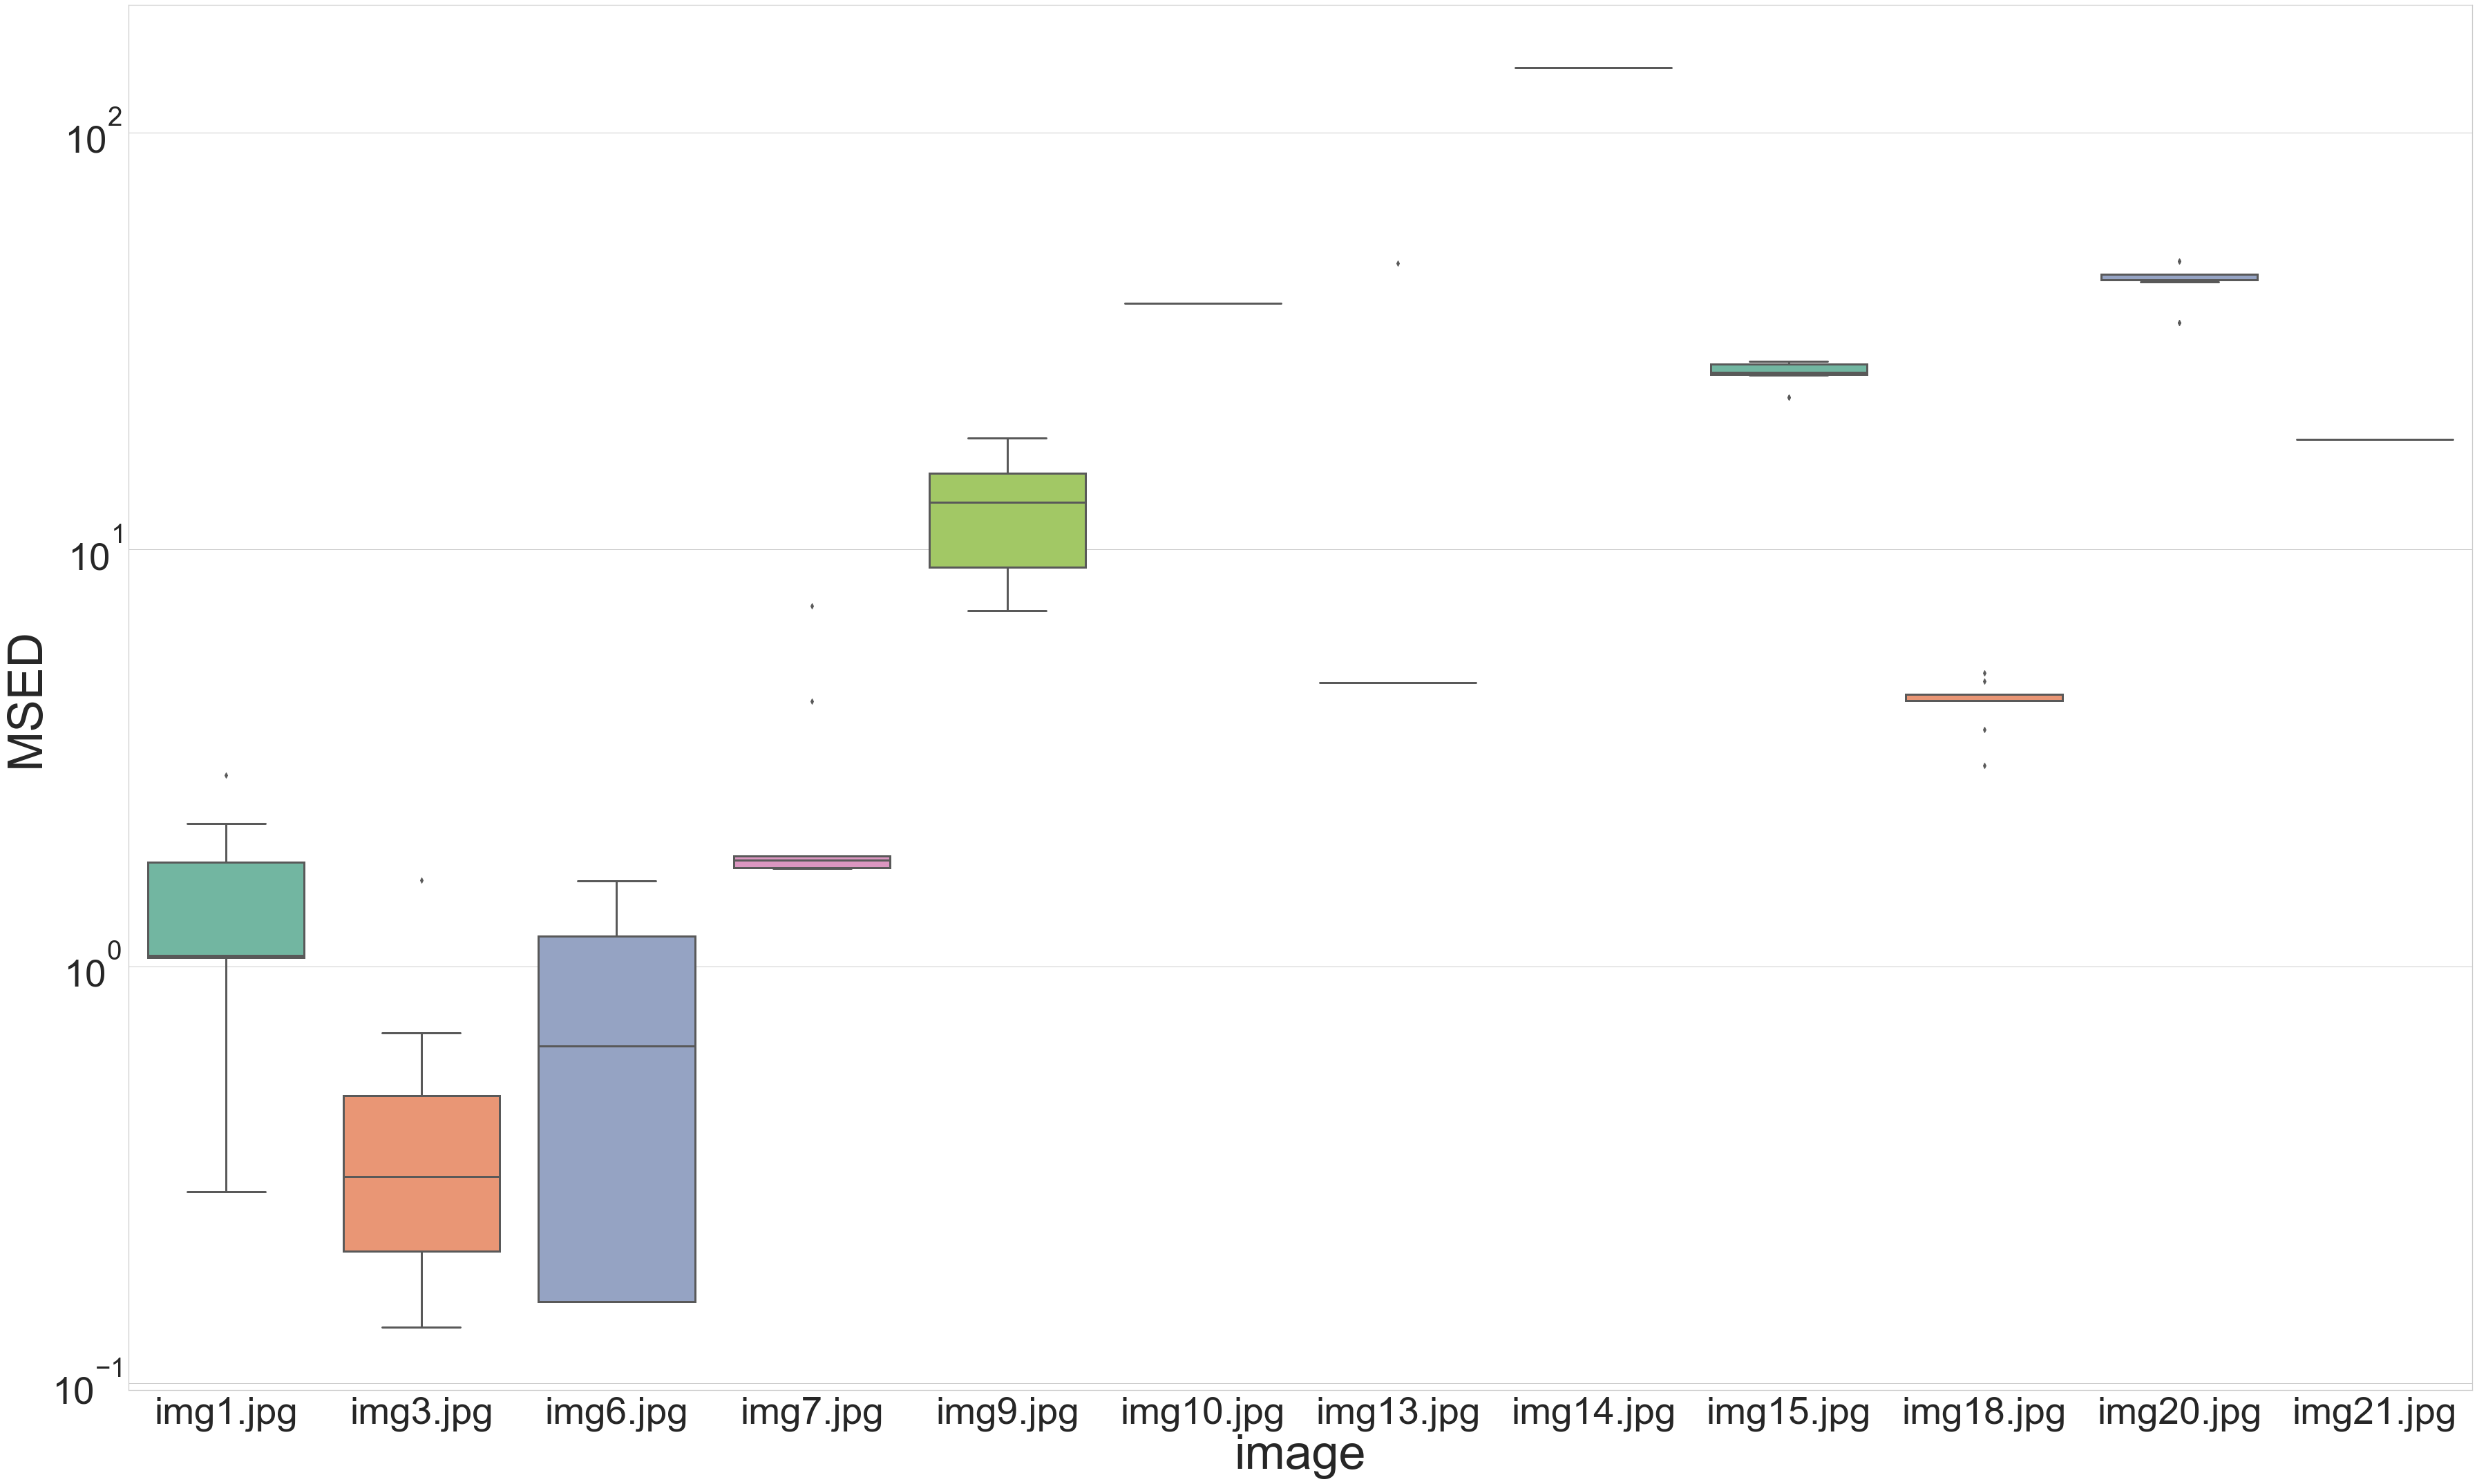

In [363]:

sns.set(font_scale=5) 
sns.set_style("whitegrid",)
ax = sns.boxplot(x="image", y="MSED",\
                 data=df_dic, showfliers = True, palette = "Set2", linewidth = 3)
# sns.despine(offset=20)
sns.set(rc={'figure.figsize':(50,30)})
# ax.legend(title = 'inlier threshold', fontsize=50, title_fontsize = 50, \
#          frameon = True,bbox_to_anchor=(1.15, 0.5),loc= 'center right' ,\
#           facecolor='white', borderaxespad=0.)
ax.set_xlabel('image', fontsize=70)
ax.set_ylabel('MSED',fontsize=70)
plt.yscale('log')
plt.tight_layout()
plt.savefig('msed_foval', dpi = 250 )

plt.show()

# The following blocks are for parameter settings

In [221]:
# test block for iteration number 
import time
dist = [2, 3, 5, 7, 10]
dist_result = []
dist_dic = {'id': [], 'msed': [], 'dist': []}
for d in dist:
    print('dist threshold : ', d)
    msed_list = []
    for i in range(10):
        print(f'run {i+1}')
        msed, msed_dic = main(gt_dic.keys(), 10, 10, d, filter_params, canny_params, hough_params)
        msed_list.append(msed)
        msed_dic
        for k in msed_dic.keys():
            dist_dic['id'].append(k)
            dist_dic['msed'].append(msed_dic[k])
            dist_dic['dist'].append(d)

#     print('list all', msed_list)
#     print('mean', np.mean(msed_list), "\n\n\n")
#     dist_result.append(np.mean(msed_list))
    

dist threshold :  2
run 1


/Users/heekim/opt/anaconda3/envs/CV/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in int_scalars


{'img1.jpg': 113.87654320987595, 'img3.jpg': 2.9140625, 'img6.jpg': 0.34793907760141396, 'img7.jpg': 29.24819882345141, 'img9.jpg': 2.985410693202873, 'img10.jpg': 50.671014640036645, 'img13.jpg': 19.111106274214624, 'img14.jpg': 464.3797530864188, 'img15.jpg': 35.12401400797024, 'img18.jpg': 5.258834029778099, 'img20.jpg': 32.90379708259057, 'img21.jpg': 53.03515625}
Accuracy(msed): 67.48798580626172

run 2
{'img1.jpg': 113.87654320987595, 'img3.jpg': 0.500422114448938, 'img6.jpg': 0.1293563834104213, 'img7.jpg': 29.136352158909403, 'img9.jpg': 2.4549257767931736, 'img10.jpg': 50.671014640036645, 'img13.jpg': 19.111106274214624, 'img14.jpg': 464.3797530864188, 'img15.jpg': 33.94919772647241, 'img18.jpg': 3.777777777777841, 'img20.jpg': 34.24173553718987, 'img21.jpg': 53.03515625}
Accuracy(msed): 67.10527841129567

run 3
{'img1.jpg': 143.99099539086126, 'img3.jpg': 2.016732965268951, 'img6.jpg': 1.149113854595386, 'img7.jpg': 29.519999999999783, 'img9.jpg': 3.9286913580246163, 'img10.j

{'img1.jpg': 1.9965397923876098, 'img3.jpg': 0.13639018075130943, 'img6.jpg': 1.19847623966939, 'img7.jpg': 1.193877551020377, 'img9.jpg': 16.19045873194271, 'img10.jpg': 38.90211014831479, 'img13.jpg': 31.249949777193706, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 4.810149943505519, 'img20.jpg': 18.031830886751973, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 25.137840756683417

run 2
{'img1.jpg': 91.10183958132151, 'img3.jpg': 0.13639018075130943, 'img6.jpg': 0.15669988692767312, 'img7.jpg': 1.766048074016691, 'img9.jpg': 9.591337377119316, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 28.239412244898116, 'img18.jpg': 5.046939515433516, 'img20.jpg': 45.6901067712564, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 32.229909188837546

run 3
{'img1.jpg': 7.53061224489797, 'img3.jpg': 0.012122126653585485, 'img6.jpg': 0.8364047646379325, 'img7.jpg': 1.766048074016691, 'img9.jpg': 8.84

{'img1.jpg': 5.447086801426904, 'img3.jpg': 1.0421699291961584, 'img6.jpg': 0.5604252060717672, 'img7.jpg': 42.46968590211815, 'img9.jpg': 0.8712792184075757, 'img10.jpg': 200.5799420819995, 'img13.jpg': 10.157024793388466, 'img14.jpg': 143.02019409861853, 'img15.jpg': 23.185617685555115, 'img18.jpg': 3.853618053560667, 'img20.jpg': 5.116770281465621, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 37.88586205533776

run 2
{'img1.jpg': 38.429444444444556, 'img3.jpg': 0.9305537922225946, 'img6.jpg': 0.7396449704142314, 'img7.jpg': 43.55555555555591, 'img9.jpg': 7.785347230948335, 'img10.jpg': 200.5799420819995, 'img13.jpg': 4.982849870993898, 'img14.jpg': 143.02019409861853, 'img15.jpg': 38.736829761566504, 'img18.jpg': 3.777777777777841, 'img20.jpg': 11.410701749031073, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 42.68961432881815

run 3
{'img1.jpg': 12.984552517264419, 'img3.jpg': 0.20688608578468026, 'img6.jpg': 0.5172683843684001, 'img7.jpg': 40.55555555555557, 'img9.jpg': 2.1

In [269]:
import pandas as pd
df = df[df.dist_threshold != 10]
# df.rename(columns = {'id' :'image', 'msed':'MSED', 'dist':'dist_threshold'}, inplace = True)

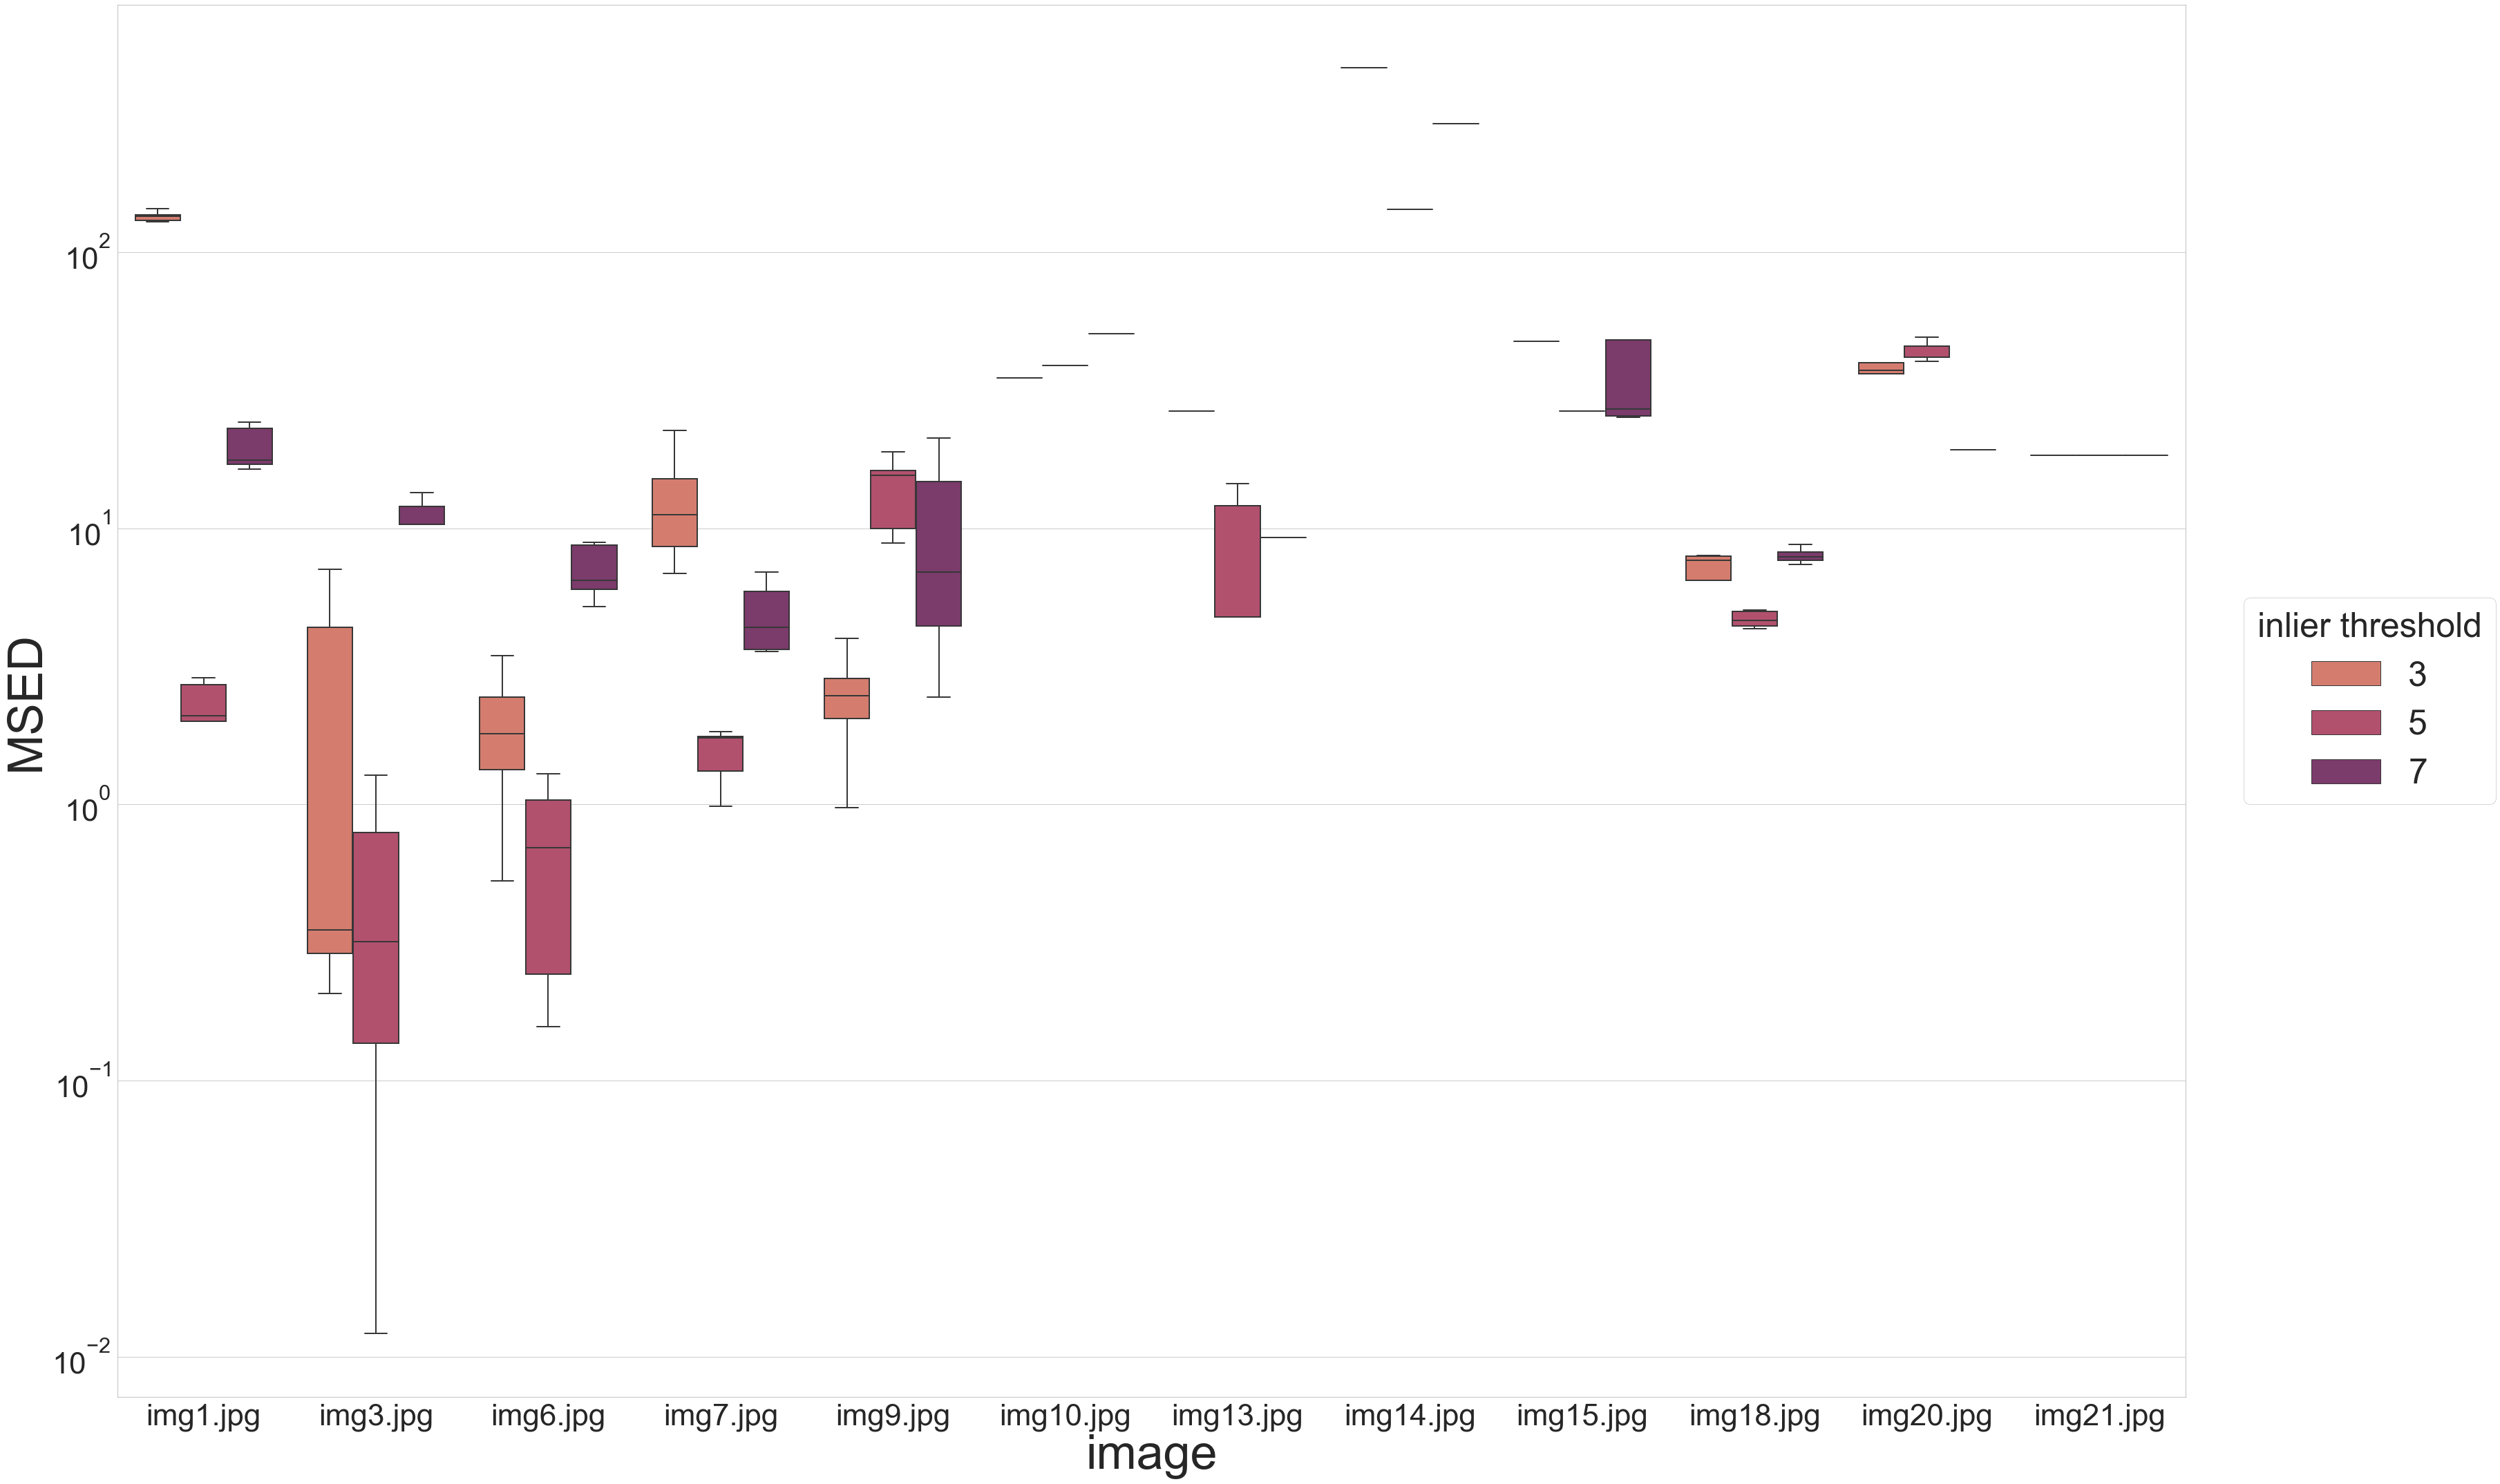

In [348]:
sns.set(font_scale=4) 
sns.set_style("whitegrid",)
ax = sns.boxplot(x="image", y="MSED", hue="dist_threshold", \
                 data=df, showfliers = False, palette="flare", linewidth = 2)
# sns.despine(offset=20)
sns.set(rc={'figure.figsize':(50,30)})
ax.legend(title = 'inlier threshold', fontsize=50, title_fontsize = 50, \
         frameon = True,bbox_to_anchor=(1.15, 0.5),loc= 'center right' ,\
          facecolor='white', borderaxespad=0.)
ax.set_xlabel('image', fontsize=70)
ax.set_ylabel('MSED',fontsize=70)
plt.yscale('log')
plt.tight_layout()
plt.savefig('msed_dist_box_log', dpi = 250 )

plt.show()

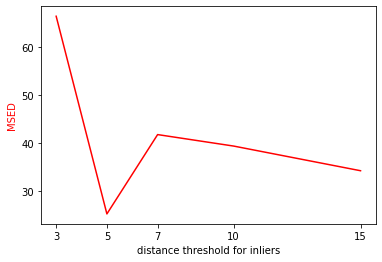

In [196]:
y = dist_result[1:]  # exclude 2 from the dist values
x = dist[1:]

fig,ax = plt.subplots()
ax.plot(x, y, color="red")
ax.set_xlabel("distance threshold for inliers")
ax.set_ylabel("MSED", c = 'r')
# ax.set_ylim([20,75])
ax.set_xticks(x)

plt.savefig('dist_inliers.png', dpi = 200)
plt.show()

In [163]:
import time
# test block for sample number 
sample = [2, 5, 10, 20]
sample_result = []
sample_time = []
for n in sample:
    print('num sample : ', n)
    msed_list = []
    for i in range(10):
        if i == 0:
            start = time.time()
        print(f'run {i+1}')
        msed, msed_dic = main(gt_dic.keys(), 10, n, 5, filter_params, canny_params, hough_params)
        msed_list.append(msed)
        if i == 0:
            run_time = time.time() -start
            print('run time:', run_time)
            sample_time.append(run_time)
    print('list all', msed_list)
    print('mean', np.mean(msed_list), "/////////\n\n\n")
    sample_result.append(np.mean(msed_list))

num sample :  2
run 1


/Users/heekim/opt/anaconda3/envs/CV/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in int_scalars


{'img1.jpg': 19.007439396138597, 'img3.jpg': 4.505252621882078, 'img6.jpg': 6.638893122660839, 'img7.jpg': 11.09261186264297, 'img9.jpg': 0.5129889226546737, 'img10.jpg': 102.6801426872766, 'img13.jpg': 54.89196675900324, 'img14.jpg': 230.9792387543251, 'img15.jpg': 68.15637246070008, 'img18.jpg': 23.51511892349003, 'img20.jpg': 23.876593295139806, 'img21.jpg': 14.660771251641895}
Accuracy(msed): 46.70978250479633

run time: 0.5083889961242676
run 2
{'img1.jpg': 70.79591836734696, 'img3.jpg': 4.329212577264123, 'img6.jpg': 8.56453516149642, 'img7.jpg': 7.210540578753726, 'img9.jpg': 959.5606420927458, 'img10.jpg': 38.90211014831479, 'img13.jpg': 38.944999999999624, 'img14.jpg': 143.02019409861853, 'img15.jpg': 28.58939207584227, 'img18.jpg': 37.96159122085031, 'img20.jpg': 34.962428867265764, 'img21.jpg': 14.660771251641895}
Accuracy(msed): 115.625194703345

run 3
{'img1.jpg': 0.5280907372400541, 'img3.jpg': 4.203450327186311, 'img6.jpg': 1.9818611742615229, 'img7.jpg': 14.897252630459

{'img1.jpg': 89.74968558562227, 'img3.jpg': 0.308980841722849, 'img6.jpg': 1.1693455894754763, 'img7.jpg': 6.765432098765539, 'img9.jpg': 11.742603550295689, 'img10.jpg': 38.90211014831479, 'img13.jpg': 14.527411986025355, 'img14.jpg': 143.02019409861853, 'img15.jpg': 28.239412244898116, 'img18.jpg': 4.810149943505519, 'img20.jpg': 40.319452706722146, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 33.15677578385091

list all [30.16931675538294, 30.27031533834997, 32.38787164052548, 38.05584142707219, 26.412884359408945, 30.604179297050564, 28.41985789224253, 27.738647487514047, 31.955719298107017, 33.15677578385091]
mean 30.917140927950452 /////////



num sample :  10
run 1
{'img1.jpg': 96.98741776937614, 'img3.jpg': 1.2785161674270376, 'img6.jpg': 0.15755138959190332, 'img7.jpg': 1.7270242247148118, 'img9.jpg': 14.669560377344713, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 4.482021042

{'img1.jpg': 1.9965397923876098, 'img3.jpg': 0.13639018075130943, 'img6.jpg': 0.15692185740968076, 'img7.jpg': 1.8367346938775442, 'img9.jpg': 8.774836590942943, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 4.810149943505519, 'img20.jpg': 45.6901067712564, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 24.585783131854786

run 9
{'img1.jpg': 1.9965397923876098, 'img3.jpg': 0.20688608578468026, 'img6.jpg': 0.15755138959190332, 'img7.jpg': 1.8367346938775442, 'img9.jpg': 8.840020926004762, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 4.33034516030002, 'img20.jpg': 45.6901067712564, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 24.55715854761078

run 10
{'img1.jpg': 1.0624349635795443, 'img3.jpg': 0.13639018075130943, 'img6.jpg': 0.15755138959190332, 'img7.jpg': 1.8367346938775442, 'img9.jpg': 

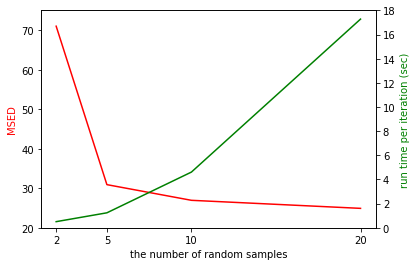

In [170]:
y = sample_result
x = sample
t = sample_time

fig,ax = plt.subplots()
ax.plot(x, y, color="red")
ax.set_xlabel("the number of random samples")
ax.set_ylabel("MSED", c = 'r')
ax.set_ylim([20,75])
ax.set_xticks(x)

ax2=ax.twinx()
ax2.plot(x, t,color="green")
ax2.set_ylabel("run time per iteration (sec)", c = 'green')
ax2.set_ylim([0,18])

plt.savefig('n_sample.png', dpi = 200)
plt.show()

In [135]:
# test block for iteration number 
import time
iters = [1, 3, 5, 7, 10, 15, 20]
iters_result = []
iters_time = []
for it in tqdm(iters):
    print('num iter : ', it)
    msed_list = []
    for i in range(10):
        if i == 0:
            start = time.time()
        print(f'run {i+1}')
        msed, msed_dic = main(gt_dic.keys(), it , 10, 5, filter_params, canny_params, hough_params)
        msed_list.append(msed)
        if i == 0:
            run_time = time.time() -start
            print('run time:', run_time)
            iters_time.append(run_time)
            
    print('list all', msed_list)
    print('mean', np.mean(msed_list), "/////////\n\n\n")
    iters_result.append(np.mean(msed_list))
    

  0%|                                                     | 0/7 [00:00<?, ?it/s]/Users/heekim/opt/anaconda3/envs/CV/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in int_scalars


num iter :  1
run 1
{'img1.jpg': 10.310249307479264, 'img3.jpg': 0.4148907199456366, 'img6.jpg': 3.9911966701353405, 'img7.jpg': 3.374807271684233, 'img9.jpg': 18.07999999999999, 'img10.jpg': 38.90211014831479, 'img13.jpg': 48.5, 'img14.jpg': 143.02019409861853, 'img15.jpg': 27.91182890653652, 'img18.jpg': 7.512396694214822, 'img20.jpg': 27.1490514905146, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 28.9577713266407

run time: 0.8946030139923096
run 2
{'img1.jpg': 195.40625, 'img3.jpg': 4.898458311075348, 'img6.jpg': 4.028099173553796, 'img7.jpg': 13.10911573198915, 'img9.jpg': 40.913892477059214, 'img10.jpg': 38.90211014831479, 'img13.jpg': 14.527411986025355, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.894608864372604, 'img18.jpg': 20.246850482656605, 'img20.jpg': 43.84034651066873, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 47.00948903304825

run 3
{'img1.jpg': 8.079999999999991, 'img3.jpg': 2.2577393992752093, 'img6.jpg': 4.8914812273307495, 'img7.jpg': 4.66435986159

 14%|██████▍                                      | 1/7 [00:08<00:52,  8.74s/it]

{'img1.jpg': 1.0058063579619434, 'img3.jpg': 2.914686889152911, 'img6.jpg': 2.5887418609535358, 'img7.jpg': 8.594263991870239, 'img9.jpg': 16.75516744111498, 'img10.jpg': 50.671014640036645, 'img13.jpg': 10.871090492576378, 'img14.jpg': 143.02019409861853, 'img15.jpg': 41.01462809917333, 'img18.jpg': 1.0617063572558347, 'img20.jpg': 41.794689026141974, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 28.218209988925082

list all [28.9577713266407, 47.00948903304825, 26.914691965020964, 28.678769544282137, 27.12456560828598, 26.497921738259578, 33.85335674380231, 38.120479074662335, 31.685197376475898, 28.218209988925082]
mean 31.706045239940323 /////////



num iter :  3
run 1
{'img1.jpg': 1.0624349635795443, 'img3.jpg': 3.0166621875839637, 'img6.jpg': 1.2913631633714786, 'img7.jpg': 2.36134216568187, 'img9.jpg': 15.085843681519606, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 27.78056788668048, 'img18.jpg': 17.1176040905

 29%|████████████▊                                | 2/7 [00:25<01:08, 13.62s/it]

{'img1.jpg': 0.5555555555555871, 'img3.jpg': 0.20688608578468026, 'img6.jpg': 1.1026267846519557, 'img7.jpg': 1.158710934085846, 'img9.jpg': 16.19045873194271, 'img10.jpg': 38.90211014831479, 'img13.jpg': 14.527411986025355, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.894608864372604, 'img18.jpg': 7.880000000000059, 'img20.jpg': 18.031830886751973, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 23.899743724029065

list all [26.821849373252636, 29.78272708803034, 23.66650723328497, 27.147383368826656, 36.98077789312188, 32.19174741700517, 25.15975528749051, 25.29901878584181, 25.383260107802496, 23.899743724029065]
mean 27.63327702786855 /////////



num iter :  5
run 1
{'img1.jpg': 1.9965397923876098, 'img3.jpg': 0.500422114448938, 'img6.jpg': 3.6115889542778814, 'img7.jpg': 11.263533080864407, 'img9.jpg': 9.894182888184591, 'img10.jpg': 38.90211014831479, 'img13.jpg': 14.527411986025355, 'img14.jpg': 143.02019409861853, 'img15.jpg': 66.66264272420952, 'img18.jpg': 4.67235327586

 43%|███████████████████▎                         | 3/7 [00:51<01:16, 19.04s/it]

{'img1.jpg': 1.9965397923876098, 'img3.jpg': 0.6942145767315794, 'img6.jpg': 0.8364047646379325, 'img7.jpg': 1.7482182209083053, 'img9.jpg': 14.669560377344713, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 28.239412244898116, 'img18.jpg': 5.046939515433516, 'img20.jpg': 43.84034651066873, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 25.175147719778042

list all [29.474746865180588, 26.063633105514423, 25.805324127991142, 24.22730259556705, 25.182275289365332, 29.05834178978556, 26.87336552646279, 28.494917312137005, 29.086333323414507, 25.175147719778042]
mean 26.944138765519646 /////////



num iter :  7
run 1
{'img1.jpg': 1.0462591198112325, 'img3.jpg': 1.608740894901134, 'img6.jpg': 0.15669988692767312, 'img7.jpg': 1.104694999167317, 'img9.jpg': 18.5, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 5.046939515433516, 'img2

 57%|█████████████████████████▋                   | 4/7 [01:23<01:12, 24.08s/it]

{'img1.jpg': 91.10183958132151, 'img3.jpg': 0.8243527091907314, 'img6.jpg': 0.9564931299651243, 'img7.jpg': 1.766048074016691, 'img9.jpg': 16.8405126379497, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.192867036011222, 'img18.jpg': 4.33034516030002, 'img20.jpg': 45.6901067712564, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 32.727725144528115

list all [23.093573587926603, 26.726602101278626, 25.25425622386784, 24.534393017482856, 24.544986805787165, 24.923803937348392, 30.8662682713334, 24.472935979653347, 25.53693085519181, 32.727725144528115]
mean 26.268147592439817 /////////



num iter :  10
run 1
{'img1.jpg': 0.5280907372400541, 'img3.jpg': 0.7351715929379669, 'img6.jpg': 0.15755138959190332, 'img7.jpg': 1.713280000000084, 'img9.jpg': 15.920369620745292, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.894608864372604, 'img18.jpg': 4.330345160300

 71%|████████████████████████████████▏            | 5/7 [02:05<01:01, 30.82s/it]

{'img1.jpg': 1.0462591198112325, 'img3.jpg': 0.500422114448938, 'img6.jpg': 0.5604252060717672, 'img7.jpg': 1.766048074016691, 'img9.jpg': 19.125, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 4.33034516030002, 'img20.jpg': 40.319452706722146, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 24.939639177791438

list all [25.08330506423086, 26.227518002385057, 25.273374792848653, 25.78642841262234, 23.973973868819943, 24.907548197175487, 25.892384329439665, 23.983629903937317, 27.051360276955688, 24.939639177791438]
mean 25.311916202620644 /////////



num iter :  15
run 1
{'img1.jpg': 0.5280907372400541, 'img3.jpg': 0.20688608578468026, 'img6.jpg': 0.15755138959190332, 'img7.jpg': 1.766048074016691, 'img9.jpg': 8.774836590942943, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 5.046939515433516, 'im

 86%|██████████████████████████████████████▌      | 6/7 [03:08<00:41, 41.81s/it]

{'img1.jpg': 1.0624349635795443, 'img3.jpg': 0.45437241817881757, 'img6.jpg': 0.15669988692767312, 'img7.jpg': 4.32433208848022, 'img9.jpg': 16.147580461240466, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 4.33034516030002, 'img20.jpg': 34.962428867265764, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 24.422159299841578

list all [24.483181409699384, 25.49259047927478, 25.129196264535377, 25.482128672790072, 25.08459818818137, 25.318814575642758, 24.76788070263595, 32.29601912304524, 25.36773678345013, 24.422159299841578]
mean 25.784430549909665 /////////



num iter :  20
run 1
{'img1.jpg': 0.5280907372400541, 'img3.jpg': 0.13639018075130943, 'img6.jpg': 0.15755138959190332, 'img7.jpg': 1.158710934085846, 'img9.jpg': 18.5, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 4.810149943505519, 'img2

100%|█████████████████████████████████████████████| 7/7 [04:31<00:00, 38.76s/it]

{'img1.jpg': 2.200788140364089, 'img3.jpg': 0.20688608578468026, 'img6.jpg': 0.5604252060717672, 'img7.jpg': 1.8367346938775442, 'img9.jpg': 8.774836590942943, 'img10.jpg': 38.90211014831479, 'img13.jpg': 4.781301775147994, 'img14.jpg': 143.02019409861853, 'img15.jpg': 26.59758111780041, 'img18.jpg': 4.810149943505519, 'img20.jpg': 45.6901067712564, 'img21.jpg': 18.326530612244724}
Accuracy(msed): 24.64230376532745

list all [25.21739314237979, 25.630588545483928, 25.135810293059908, 26.12179449961184, 23.66822273866661, 24.551228305678986, 25.050295979065115, 24.712163926230797, 24.73943436324619, 24.64230376532745]
mean 24.946923555875063 /////////





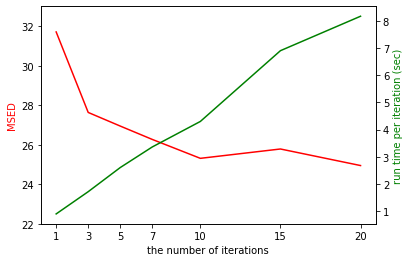

In [160]:
y = iters_result
x = iters
t = iters_time

fig,ax = plt.subplots()
ax.plot(x, y, color="red")
ax.set_xlabel("the number of iterations")
ax.set_ylabel("MSED", c = 'r')
ax.set_ylim([22,33])
ax.set_xticks(x)

ax2=ax.twinx()
ax2.plot(x, t,color="green")
ax2.set_ylabel("run time per iteration (sec)", c = 'green')

plt.savefig('n_iter.png', dpi = 200)
plt.show()